Задача -  обучить классификатор на основе CNN
Метрика - Mean F1-Score

Обучающая и тестовая выборка состоят из отрывков из мультсериала Симпсоны. Каждая картинка представлена в формате jpg c необходимой меткой - названием персонажа изображенного на ней. Тест был поделен на приватную и публичную часть в соотношении 95/5.

In [ ]:
import torch
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [ ]:
import pandas as pd

import cv2
import statistics
from scipy.stats import kurtosis, skew
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import PIL
from PIL import Image, ImageDraw

import seaborn as sns


import torch.nn as nn
import torchvision
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as F
from torchvision import datasets
import torchvision.transforms as transforms

from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import os
import pickle
from multiprocessing.pool import ThreadPool
from torch.utils.data.sampler import WeightedRandomSampler
from tqdm import tqdm, tqdm_notebook
from tqdm.notebook import tqdm, trange
from collections import Counter
print(torch.__version__)

2.0.0


In [ ]:
torch.cuda.empty_cache()
!nvidia-smi

Mon Nov 20 08:31:27 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    26W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)

        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [ ]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [ ]:
# типы датасетов
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

In [ ]:
# пути к датасетам
TRAIN_DIR = Path('/kaggle/input/journey-springfield/train/simpsons_dataset')
TEST_DIR = Path('/kaggle/input/journey-springfield/testset/testset')
# список файлов для train, val датасетов
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
# список файлов для test датасета
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))
# посмотрим на количество файлов в этих датасетах
print('Количество объектов в train и val датасете {}'.format(len(train_val_files)))
print('Количество объектов в test датасете {}'.format(len(test_files)))

Количество объектов в train и val датасете 20933
Количество объектов в test датасете 991


In [ ]:
train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.2,
                                          stratify=train_val_labels, random_state=42)

Проанализируем классы изображений

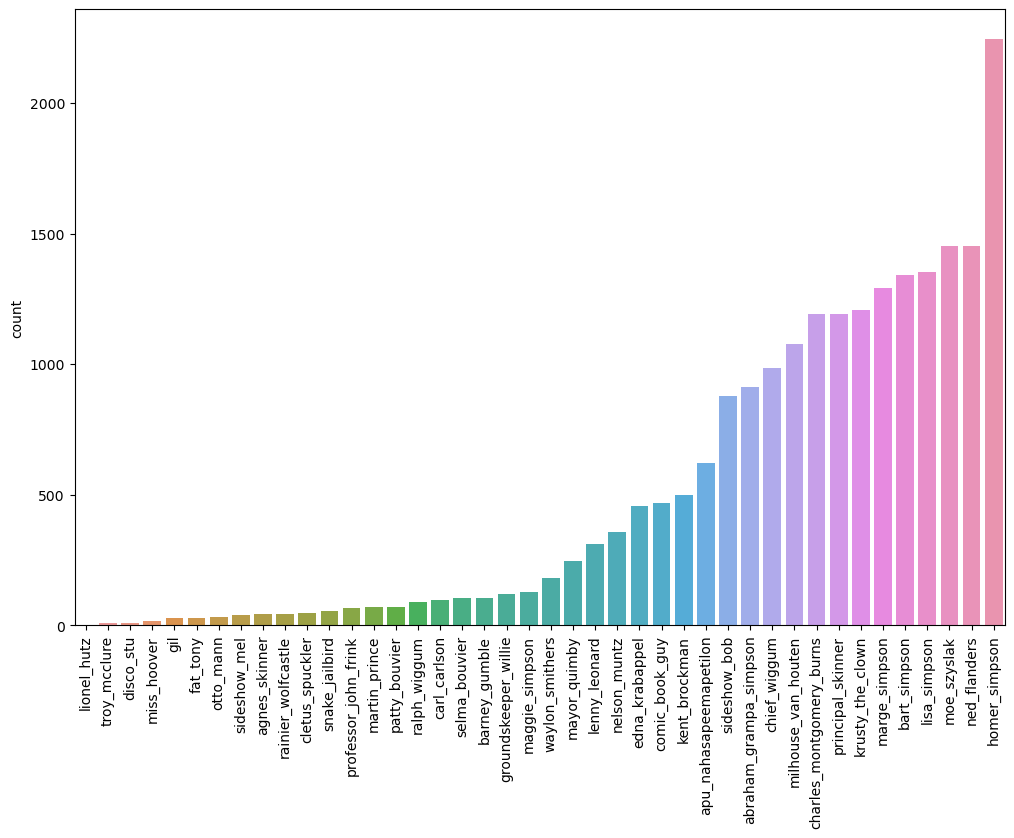

In [ ]:
# строим диаграмму
data = pd.Series(train_val_labels).value_counts().sort_values().to_frame("count")
plt.figure(figsize=(12,8))
sns.barplot(x=data.index , y='count', data=data)
plt.xticks(rotation=90)
plt.show()

Количество изображений по персонажам из  в тренировочном датасете распределены неравномерно. Нужна аугментация данных для балансирования выборки путем синтеза новых объектов для редких классов. Будем использовать WeightedRandomSampler

In [ ]:
from torchvision.transforms.functional import InterpolationMode
# случайная последовательность преобразований данных с использованием
# 'transforms.RandomChoice'.  Это позволяет случайным образом выбирать
# одно из нескольких преобразований для аугментации данных.

augmentation  = transforms.RandomChoice([
    transforms.Compose([
    transforms.CenterCrop(size=224),
    transforms.RandomCrop(150),
    transforms.Resize(size=224)
    ]),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomPerspective(distortion_scale=0.5, p=0.5,
                                 interpolation=InterpolationMode.BILINEAR, fill=0),
    transforms.RandomRotation(degrees=45)
])

#  Создается последовательность преобразований, которая включает в себя
# случайный выбор аугментаций, изменение размера изображения,
# нормализацию и преобразование в тензор

transform_train = transforms.Compose([
    augmentation ,
    transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
    transforms.Lambda(lambda x: np.array(x, dtype="float32") / 255),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Создается объект ImageFolder, предназначенный для работы с изображениями.
# к чему применяется-TRAIN_DIR, какие преобразования - transform_train
train_dataset = datasets.ImageFolder(root=TRAIN_DIR, transform=transform_train)

In [ ]:
# количество экземпляров каждого класса в train_dataset
class_count = Counter(train_dataset.targets)

# веса для каждого класса, обратно пропорциональные количеству экземпляров класса
class_weights = {i: 1/c for i, c in class_count.items()}

# список для хранения весов каждого сэмпла в обучающей выборке
sample_weights = [0] * len(train_dataset)
for i, (data, label) in enumerate(tqdm(train_dataset)):
    class_weight = class_weights[label]
    sample_weights[i] = class_weight

N = max(class_count.values()) * len(class_count)
# Создается объект WeightedRandomSampler с использованием ранее вычисленных весов.
# Возвращает сэмплы с вероятностью, пропорциональной их весам.
train_sampler = WeightedRandomSampler(sample_weights, num_samples=N, replacement=True)

# Создается загрузчик(DataLoader), который будет использоваться для итерации по обучающей выборке.
# В агрузчике используется созданный взвешенный сэмплер (train_sampler).
train_loader = DataLoader(train_dataset, batch_size=128, sampler=train_sampler, num_workers=2)

  0%|          | 0/20933 [00:00<?, ?it/s]

In [ ]:
train_dataset = SimpsonsDataset(train_files, mode='train')
val_dataset = SimpsonsDataset(val_files, mode='val')
test_dataset = SimpsonsDataset(test_files, mode='test')

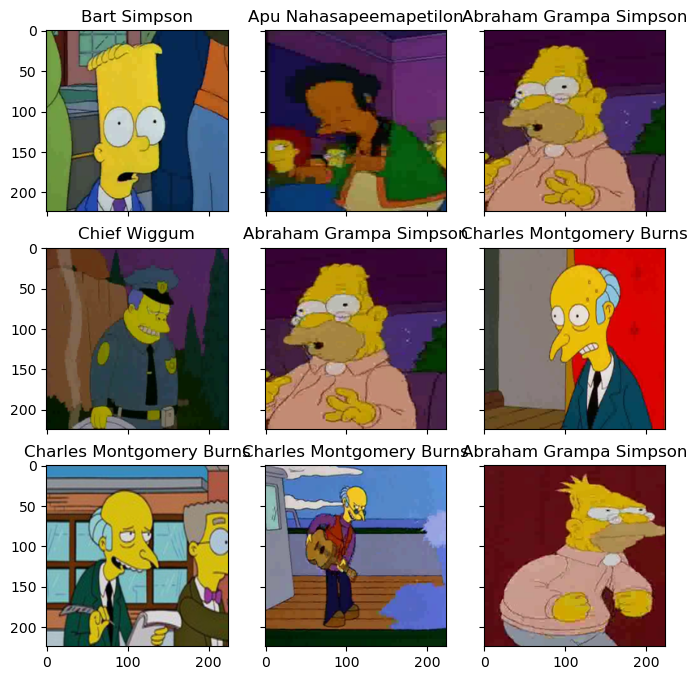

In [ ]:
# посмотрим на рандомные картинки
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

**Инициализация модели, обучение на 1 эпохе**

В качестве transfer learning выберем предобученную сеть resnet152 и Fine Tuning, заменим ей последний слой под нужное количество классов.**

В качестве оптимизатора - AdamW

In [ ]:
from torch.optim import lr_scheduler
from torchvision import models


model = models.resnet152(pretrained=True)
n_classes = len(np.unique(train_val_labels)) # количество классов в задаче
num_features = model.fc.in_features # число фичей resnet152
model.fc = nn.Linear(num_features, n_classes)
model = model.to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|██████████| 230M/230M [00:00<00:00, 291MB/s]


In [ ]:
def fit_epoch(model, train_loader, criterion, optimizer):
    model.train(True)

    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [ ]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [ ]:
def train(train_files, val_files, model, epochs, opt, criterion,batch_size, scheduler=None):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = opt
        criterion = criterion

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)

            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            if scheduler is not None:
                scheduler.step()

    return history

In [ ]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []

        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [ ]:
# готовим датасеты для работы
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

**Обучение**

In [ ]:
history = train(train_dataset, val_dataset, model, 5, optimizer, criterion,32, scheduler=exp_lr_scheduler)

# def    train(train_files, val_files, model, epochs, opt, criterion,batch_size, scheduler=None):


epoch:   0%|          | 0/5 [00:00<?, ?it/s]

loss 0.5233245629158325

Epoch 001 train_loss: 0.5233     val_loss 0.1968 train_acc 0.8798 val_acc 0.9525
loss 0.1168888492017422

Epoch 002 train_loss: 0.1169     val_loss 0.1319 train_acc 0.9724 val_acc 0.9692
loss 0.06793749920474818

Epoch 003 train_loss: 0.0679     val_loss 0.1460 train_acc 0.9839 val_acc 0.9670
loss 0.020723986257547036

Epoch 004 train_loss: 0.0207     val_loss 0.0854 train_acc 0.9952 val_acc 0.9802
loss 0.009010537747791128

Epoch 005 train_loss: 0.0090     val_loss 0.0822 train_acc 0.9986 val_acc 0.9818


In [ ]:
loss, acc, val_loss, val_acc = zip(*history)

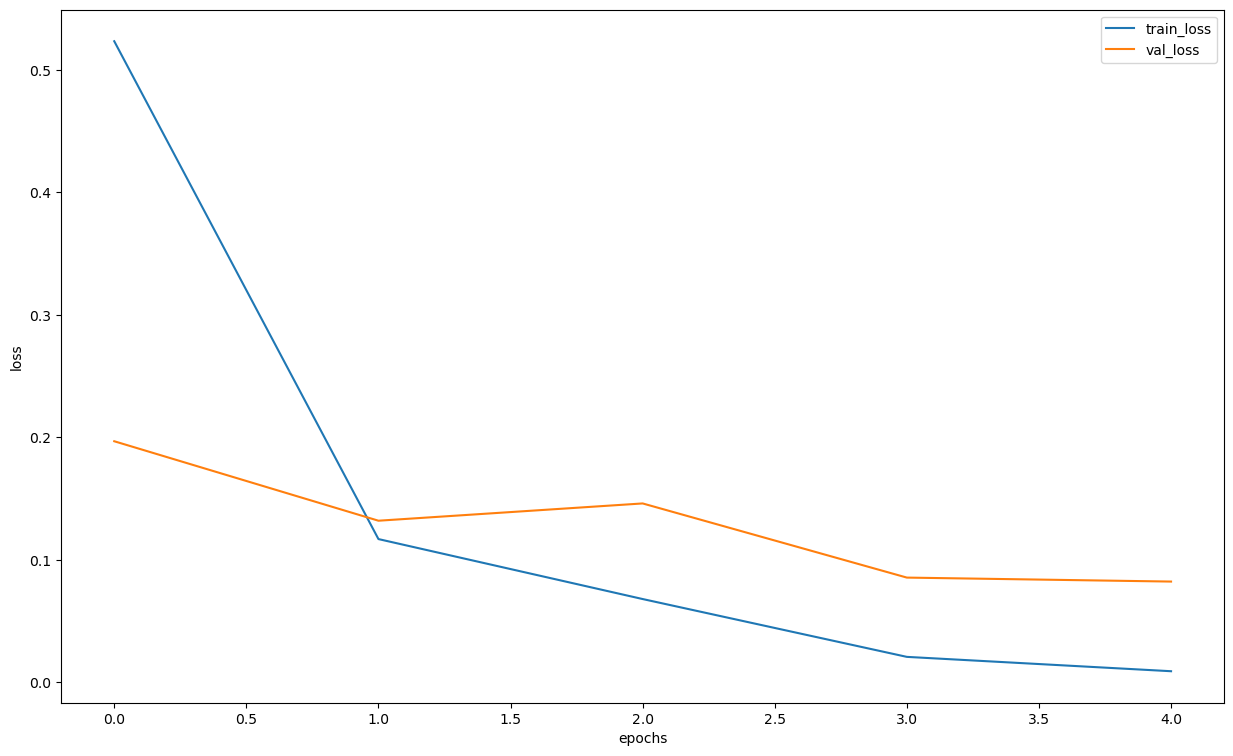

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

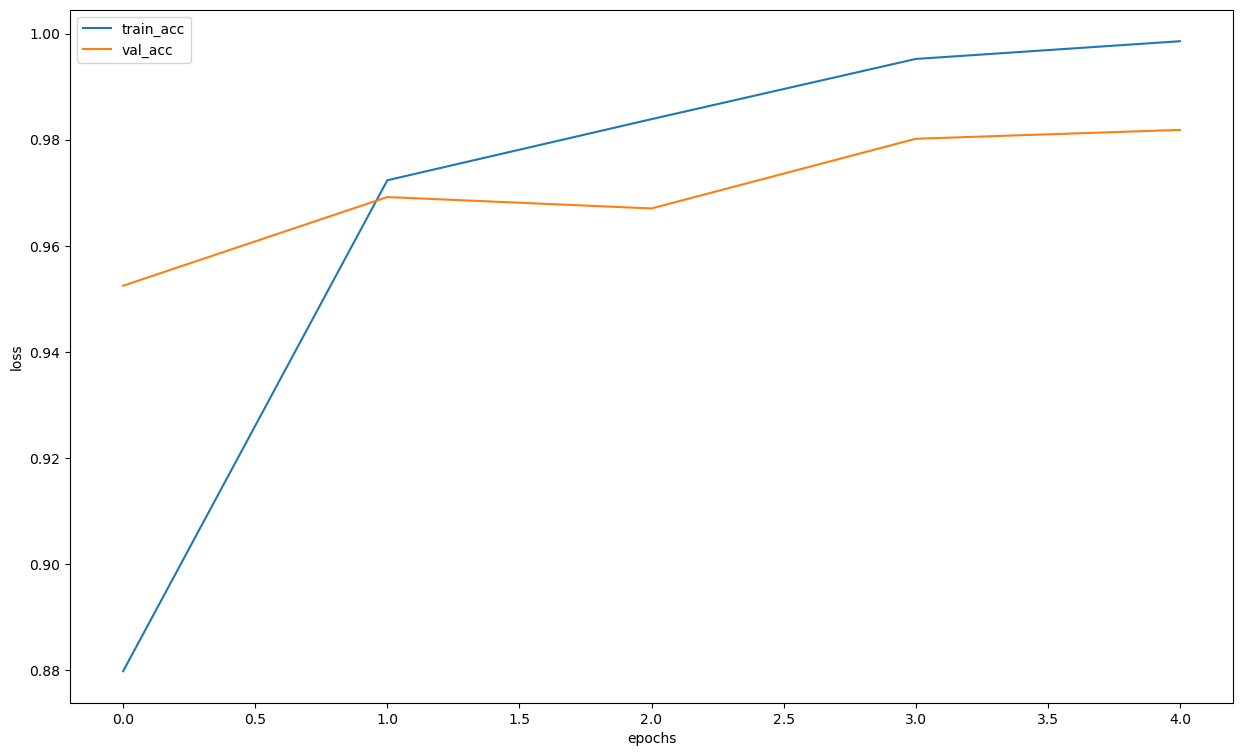

In [ ]:
val_acc = [x.cpu() for x in val_acc]
plt.figure(figsize=(15, 9))
plt.plot(acc, label="train_acc")
plt.plot(val_acc, label="val_acc")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()


In [ ]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [ ]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(model, ex_img.unsqueeze(0))

In [ ]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(model, imgs)

In [ ]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [ ]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]
lst = list(label_encoder.classes_)
preds_class = [lst.index(i) for i in preds_class]

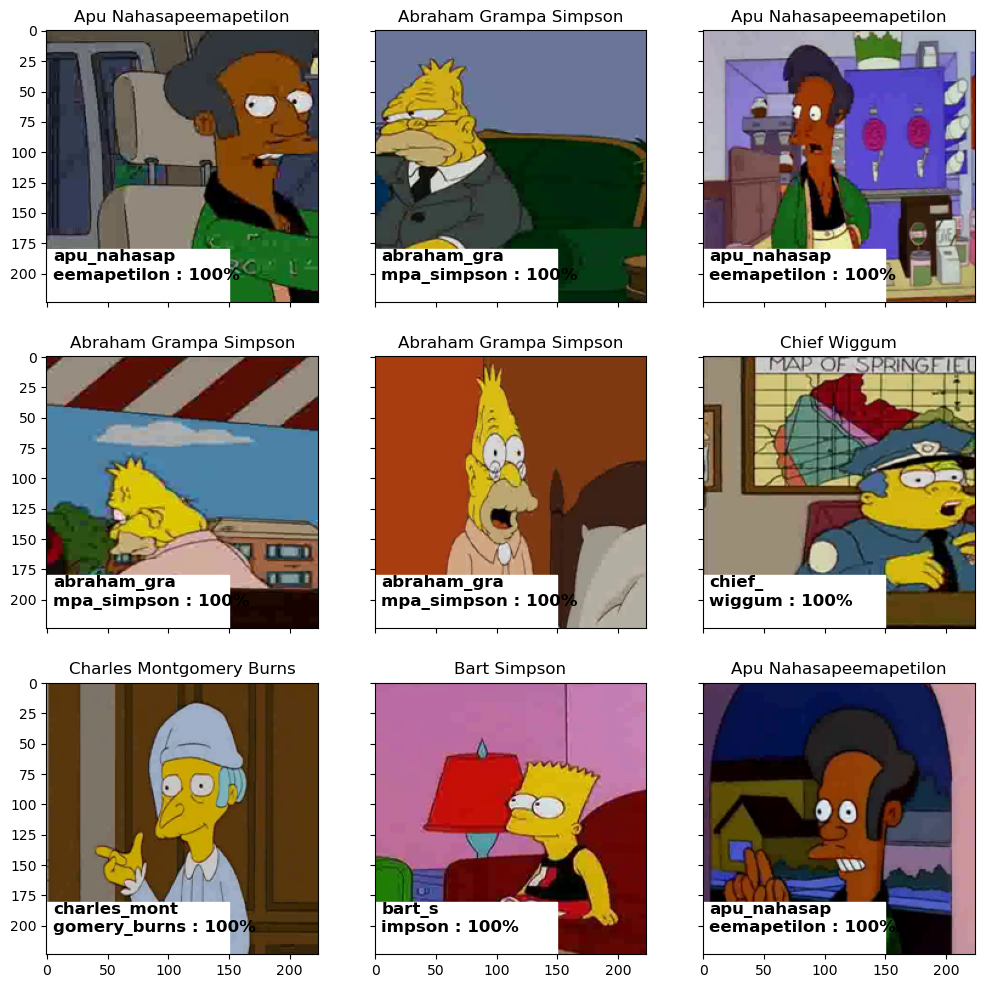

In [ ]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

    actual_text = "Actual : {}".format(img_label)

    fig_x.add_patch(patches.Rectangle((0, 180),150,50,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(model, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)

    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)

    fig_x.text(5, 180, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=12, color='black',fontweight='bold')

In [ ]:
from sklearn.metrics import f1_score
F1 = f1_score(actual_labels, preds_class, average='weighted')
print(f'Weighted f1-score: {F1}')

Weighted f1-score: 0.95


In [ ]:
probs = predict(model, test_loader)

preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [ ]:
import pandas as pd
submission = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
submission.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [ ]:
submission.to_csv('submission.csv', index=False)